In [22]:
from functions import transform_raw_data, clean_df, impute_fit_df, impute_transform_df

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.metrics import  f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split,  StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from hyperopt import fmin, tpe, hp, STATUS_OK

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

In [2]:
# creating dictionary of categorical column names : corresponding one-hot encoded columns names
# this is used to make sure every X dataset in the CV has the same columns
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
cols = ['day_of_week','time','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
        'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty','casualty_severity',
        'pedestrian_crossing_physical_facilities','vehicle_subtype']
df = df[cols]
categorical_columns = [col for col in df.select_dtypes(include='object').columns if col not in ['time','casualty_severity']] + ['speed_limit']
df = clean_df(df)
categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler = impute_fit_df(df)
df = impute_transform_df(df, categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler, df.columns)

encoded_cols_dict = {}

for col in categorical_columns:
    encoded_cols = [encoded_col for encoded_col in df.columns if col in encoded_col]
    if len(encoded_cols) > 0:
        encoded_cols_dict[col] = encoded_cols

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [3]:
# custom Transformer class for applying preprocessing in pipeline
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_encoded_cols=None):
        self.categorical_freqs = None
        self.continuous_medians_grouped = None
        self.continuous_medians = None
        self.vars_to_groupby = None
        self.scaler = None
        self.features = None
        self.one_hot_encoded_cols = one_hot_encoded_cols

    # fit is only called on the train data
    def fit(self, X, y=None):
        # calculate impute values
        self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped, self.continuous_medians, self.scaler = impute_fit_df(X)
        return self

    # transform is called on the both the train and test data
    def transform(self, X, y=None):
        # apply the preprocessing function to the data
        df = impute_transform_df(X, self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped,
                                 self.continuous_medians, self.scaler, X.columns,
                                 encoded_cols_dict=encoded_cols_dict, one_hot_encoded_cols=self.one_hot_encoded_cols)
        self.features = df.columns
        return df

In [4]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
cols = ['day_of_week','time','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
        'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty','casualty_severity',
        'pedestrian_crossing_physical_facilities','vehicle_subtype']
df['casualty_grievous_injury'] = np.where(df['casualty_severity'] == "Slight", 0, 1)
target = 'casualty_grievous_injury'
df = df[cols + [target]]
df = clean_df(df)
df = df[df != "Missing"]
df.dropna(how='any', inplace=True)
df['time_period'] = (df.time.str.slice(start=0, stop=2).astype('int') // 4)
df['time_period'] = (df['time_period'] * 4).astype('str') + ':00 - ' + ((df['time_period'] + 1) * 4).astype('str') + ':00'

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [5]:
features = ['age_of_casualty','weather_conditions','light_conditions',
            'vehicle_type','junction_detail','road_surface_conditions',
            'pedestrian_crossing_physical_facilities',
            'time_period','first_road_class','road_type',
            'second_road_class','vehicle_subtype','speed_limit','day_of_week']
one_hot_encoded_cols = [
    'day_of_week_Saturday',
    'day_of_week_Sunday',
    'time_period_0:00 - 4:00',
    'first_road_class_B',
    'first_road_class_Unclassified',
    'first_road_class_C',
    'road_type_Single carriageway',
    'junction_detail_Not at junction or within 20 metres',
    'junction_detail_Roundabout',
    'junction_detail_Other junction',
    'junction_detail_Mini-roundabout',
    'junction_detail_Private drive or entrance',
    'second_road_class_Not at junction or within 20 metres',
    'second_road_class_A',
    'second_road_class_B',
    'second_road_class_C',
    'light_conditions_Daylight',
    'weather_conditions_Fine no high winds',
    'weather_conditions_Other',
    'road_surface_conditions_Dry',
    'vehicle_subtype_7. Bike',
    'vehicle_subtype_5. Car',
    'vehicle_subtype_6. Motorbike',
    'vehicle_subtype_1. HGV',
    'vehicle_type_Van / Goods 3.5 tonnes mgw or under',
    'pedestrian_crossing_physical_facilities_No physical crossing facilities within 50 metres',
    'pedestrian_crossing_physical_facilities_Zebra',
    'pedestrian_crossing_physical_facilities_Central refuge',
    'pedestrian_crossing_physical_facilities_Pedestrian phase at traffic signal junction',
]

In [6]:
# baseline accuracy -> dummy classifier predicting the most frequent class
for strategy in ["most_frequent", "uniform", "stratified", "prior"]:
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', DummyClassifier(strategy=strategy))
    ])
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred_dummy = pipeline.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_dummy)
    f1 = f1_score(y_test, y_pred_dummy)
    print(auc, f1)

0.5 0.0
0.503232431753464 0.3405483405483405
0.48898447657723026 0.24292615596963424
0.5 0.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [8]:
counter = Counter(df[target])
print(counter)

Counter({0: 10343, 1: 3631})


In [9]:
def run_experiment(features, param_distributions, n_splits=4, n_iter=40, classifier=None, one_hot_encoded_cols=None, plot_param_charts=True):

    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('classifier', classifier)
    ])
    cv = StratifiedKFold(n_splits=n_splits)
    scoring = {
        "f1": make_scorer(f1_score),
        "auc": make_scorer(roc_auc_score)
    }
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring,  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42,  # Reproducibility
        refit="auc",
        return_train_score=True
    )
    random_search.fit(df[features], df[target])
    print(random_search.best_score_, random_search.best_params_)

    clf = random_search.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()

    # for each parameter, plot line graphs of the train auc score, test auc score, and train - test score (to identify overfitting)
    if plot_param_charts:
        cv_results_df = pd.DataFrame(random_search.cv_results_)
        params = list(cv_results_df.params[0].keys())
        cv_results_df['train_test_diff_auc'] = cv_results_df['mean_train_auc'] - cv_results_df['mean_test_auc']

        num_cols = 3
        num_rows = (3*len(param_distributions) + num_cols - 1) // num_cols
        fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, 4*num_rows))
        ax = ax.flatten()

        for i, param in enumerate(params):
            sns.lineplot(cv_results_df, x='param_' + param, y='mean_test_auc', label='Test AUC', ax=ax[i*3+0])
            sns.lineplot(cv_results_df, x='param_' + param, y='mean_train_auc', label='Train AUC', ax=ax[i*3+1])
            sns.lineplot(cv_results_df, x='param_' + param, y='train_test_diff_auc', label='Train-Test AUC Difference', ax=ax[i*3+2])

        plt.legend()
        plt.show()
    
    return random_search

##### In this notebook, I will try:
- using different classification models, tuning the hyperparameters of each
- using an ensemble of different classification models

What I learnt from notebook V1:
- Using 3 target categories very challenging because there are so few fatal cases, and the distinction between serious and fatal is vague -> switch to 2 categories of slight and grievous
- Don't need have a balanced dataset for all classification models, but SVM is one where you do
- Using all the data will probably give better results
- There are very few features that can clearly differentiate the 2 classes, so need a complex model -> the best random forest model I could find had very low bias

#### 1. Random forest

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV 1/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 1/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; auc: (train=0.522, test=0.511) f1: (train=0.106, test=0.073) total time=   7.7s
[CV 2/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 2/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; auc: (train=0.511, test=0.506) f1: (train=0.055, test=0.038) total time=   7.2s
[CV 3/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 3/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; auc: (train=0.511, test=0.510) f1: (train=0.053, test=0.055) total time=   7.2s
[CV 4/4; 1/40] START classifier__ma

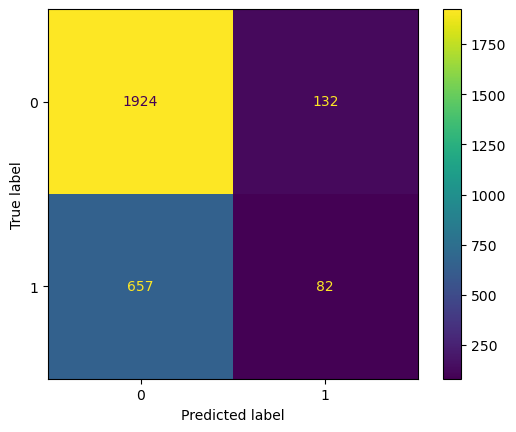

In [30]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(2, 400, 50)],
        "classifier__max_features": [int(i) for i in np.linspace(1, 37, 30)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 750, 50)] + [None]
    }
classifier = RandomForestClassifier(n_estimators=750)
random_search = run_experiment(features, param_distributions, n_iter=40, n_splits=4, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371
[CV 1/3; 1/200] END classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371; auc: (train=0.513, test=0.510) f1: (train=0.063, test=0.054) total time=   8.4s
[CV 2/3; 1/200] START classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371
[CV 2/3; 1/200] END classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371; auc: (train=0.520, test=0.506) f1: (train=0.094, test=0.047) total time=   7.4s
[CV 3/3; 1/200] START classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371
[CV 3/3; 1/200] END classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371; auc: (train=0.502, test=0.501) f1: (train=0.008, test=0.007) total time=   8.0s
[CV 1/3; 2/200] START classi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


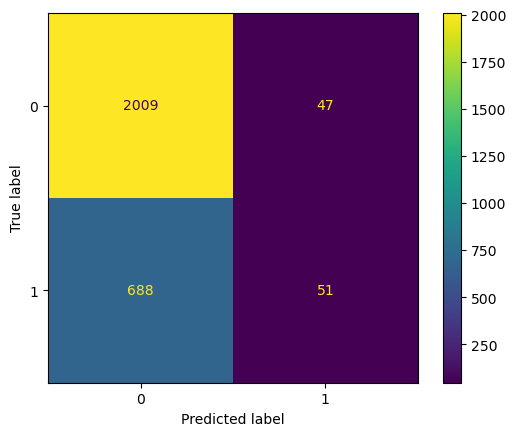

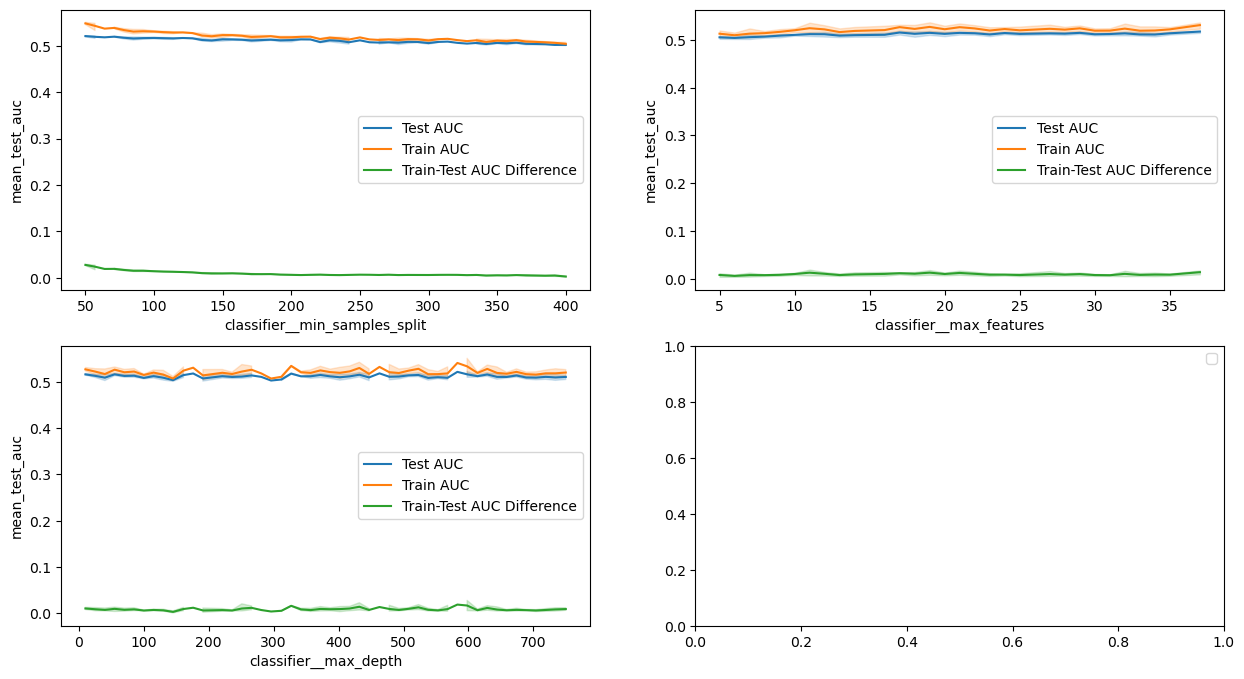

In [62]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(50, 400, 50)],
        "classifier__max_features": [int(i) for i in np.linspace(5, 37, 30)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 750, 50)] + [None]
    }
classifier = RandomForestClassifier(n_estimators=750)
random_search = run_experiment(features, param_distributions, n_iter=200, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

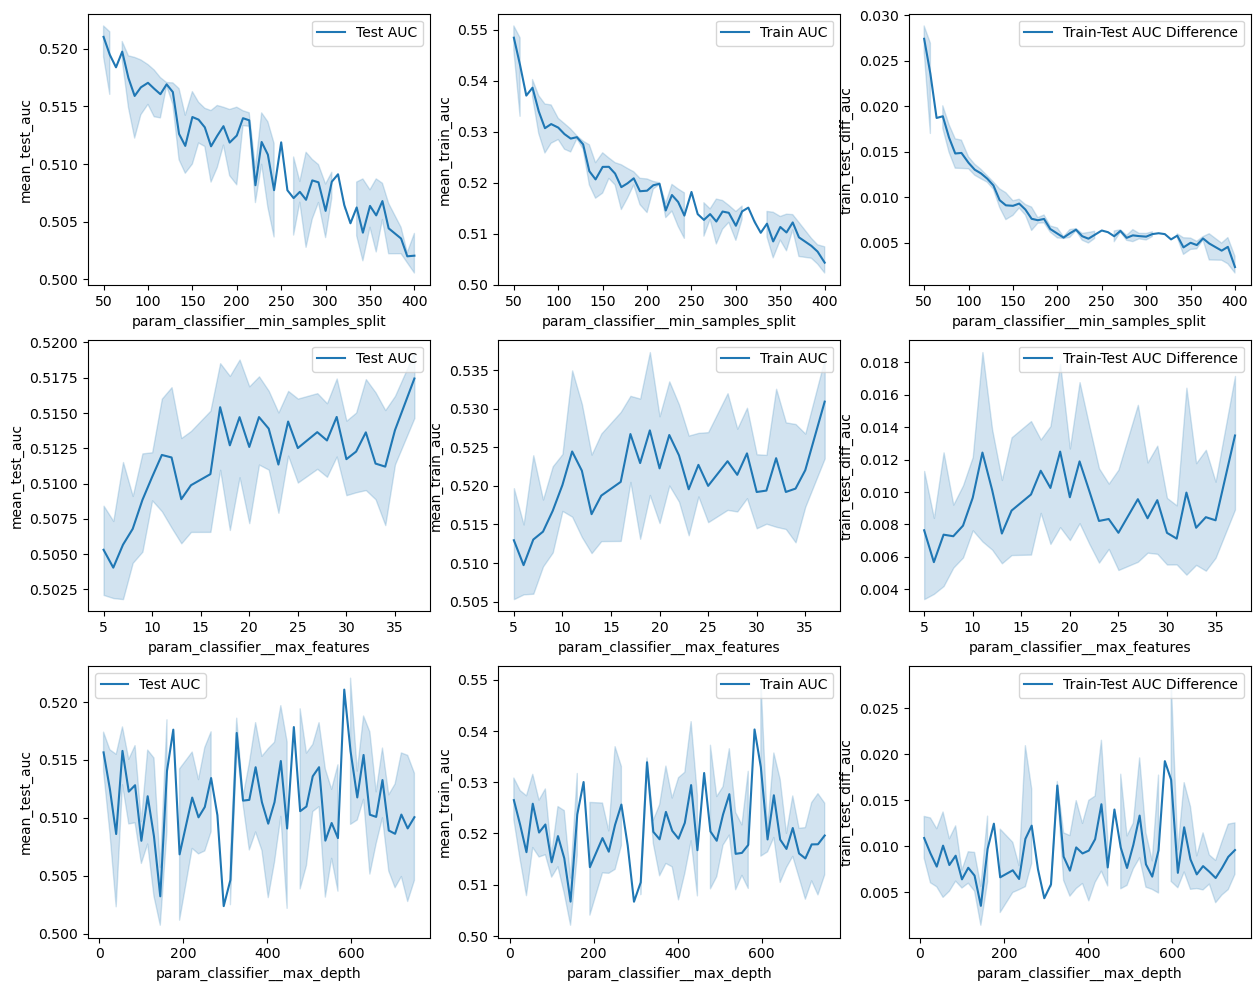

In [63]:
# for each parameter, plot line graphs of the train auc score, test auc score, and train - test score (to identify overfitting)
def plot_random_search(random_search):
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    params = list(cv_results_df.params[0].keys())
    cv_results_df['train_test_diff_auc'] = cv_results_df['mean_train_auc'] - cv_results_df['mean_test_auc']

    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 12))
    ax = ax.flatten()

    for i, param in enumerate(params):
        sns.lineplot(cv_results_df, x='param_' + param, y='mean_test_auc', label='Test AUC', ax=ax[i*3+0])
        sns.lineplot(cv_results_df, x='param_' + param, y='mean_train_auc', label='Train AUC', ax=ax[i*3+1])
        sns.lineplot(cv_results_df, x='param_' + param, y='train_test_diff_auc', label='Train-Test AUC Difference', ax=ax[i*3+2])

    plt.legend()
    plt.show()

plot_random_search(random_search)

- optimal min_samples_split 150-250
- max_features the higher the better, maybe with the exception of the max where the train-test diff jumps up
- max_depth does not seem to make much difference, maybe slight improvement in test auc from 200 to 600

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203
[CV 1/10; 1/5] END classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203; auc: (train=0.521, test=0.508) f1: (train=0.103, test=0.057) total time=  20.0s
[CV 2/10; 1/5] START classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203
[CV 2/10; 1/5] END classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203; auc: (train=0.526, test=0.506) f1: (train=0.119, test=0.060) total time=  21.2s
[CV 3/10; 1/5] START classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203
[CV 3/10; 1/5] END classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203; auc: (train=0.521, test=0.525) f1: (train=0.099, test=0.111) total time=  21.1s
[CV 4/10; 1/5] START classifier__max

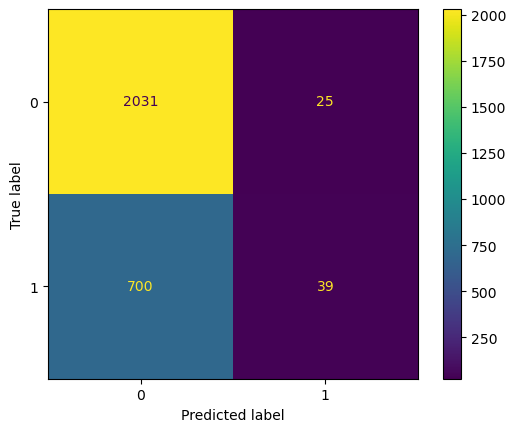

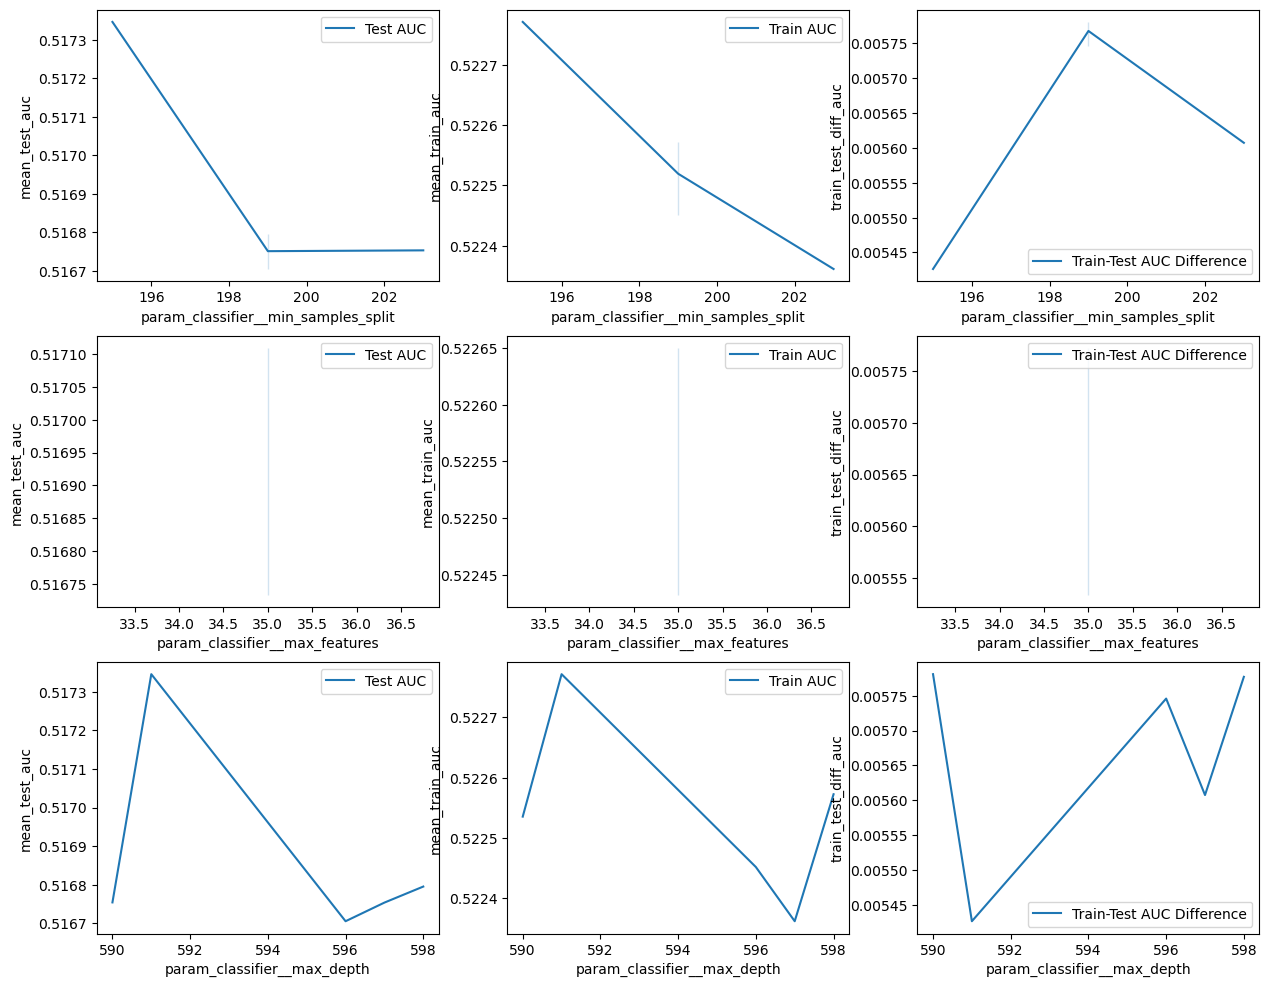

In [66]:
param_distributions = {
        "classifier__min_samples_split": [i for i in range(195, 205)],
        "classifier__max_features": [35],
        "classifier__max_depth": [i for i in range(590, 601)]
    }
classifier = RandomForestClassifier(n_estimators=1000)
random_search = run_experiment(features, param_distributions, n_iter=5, n_splits=10, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols
                               , plot_param_charts=False)

In [67]:
classifier = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
random_search = run_experiment(features, param_distributions, n_iter=5, n_splits=10, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols
                               , plot_param_charts=False)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203
[CV 1/10; 1/5] END classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203; auc: (train=0.636, test=0.562) f1: (train=0.470, test=0.358) total time=  21.6s
[CV 2/10; 1/5] START classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203
[CV 2/10; 1/5] END classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203; auc: (train=0.638, test=0.546) f1: (train=0.473, test=0.344) total time=  24.2s
[CV 3/10; 1/5] START classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203
[CV 3/10; 1/5] END classifier__max_depth=597, classifier__max_features=35, classifier__min_samples_split=203; auc: (train=0.639, test=0.565) f1: (train=0.474, test=0.384) total time=  23.6s
[CV 4/10; 1/5] START classifier__max

KeyboardInterrupt: 

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371
[CV 1/3; 1/200] END classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371; auc: (train=0.611, test=0.550) f1: (train=0.444, test=0.375) total time=   5.3s
[CV 2/3; 1/200] START classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371
[CV 2/3; 1/200] END classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371; auc: (train=0.608, test=0.564) f1: (train=0.436, test=0.383) total time=   5.4s
[CV 3/3; 1/200] START classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371
[CV 3/3; 1/200] END classifier__max_depth=161, classifier__max_features=21, classifier__min_samples_split=371; auc: (train=0.608, test=0.575) f1: (train=0.435, test=0.404) total time=   6.2s
[CV 1/3; 2/200] START classi

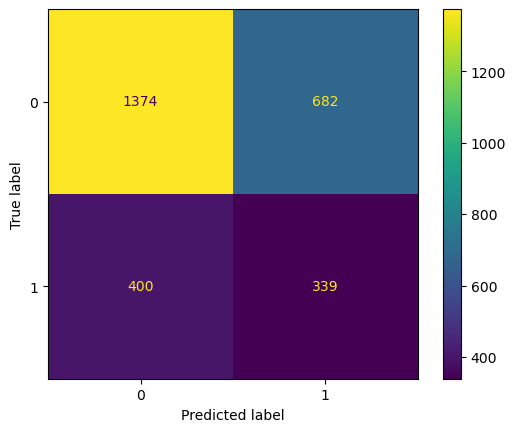

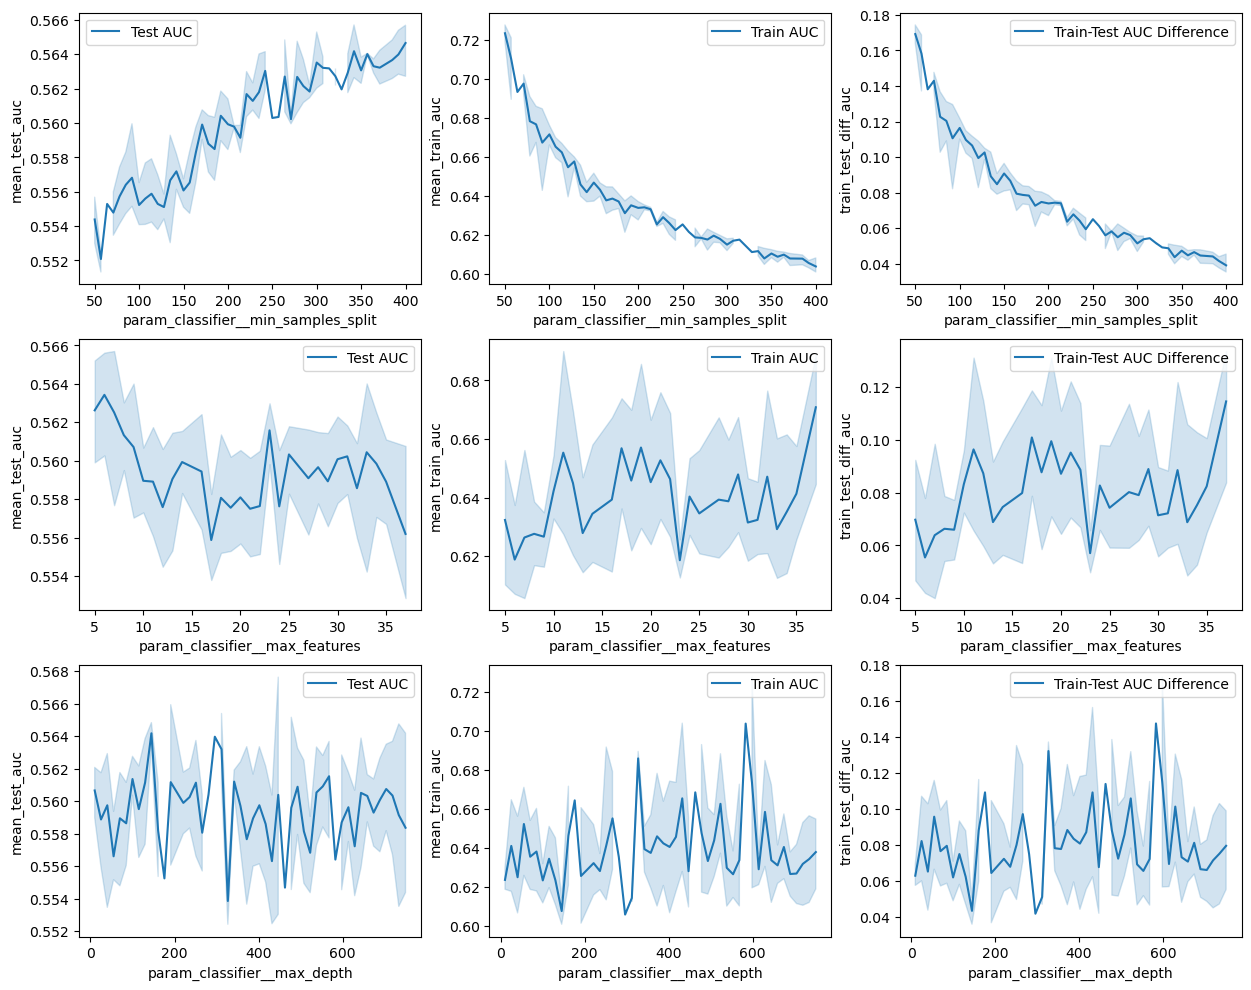

In [68]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(50, 400, 50)],
        "classifier__max_features": [int(i) for i in np.linspace(5, 37, 30)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 750, 50)] + [None]
    }
classifier = RandomForestClassifier(n_estimators=500, class_weight='balanced')
random_search = run_experiment(features, param_distributions, n_iter=200, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

Test auc seems to be improving almost linearly with increasing min_samples_split, with overfitting reducing. Therefore, try increasing the range of min_samples_split further:

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 1/100] START classifier__max_depth=454, classifier__max_features=27, classifier__min_samples_split=942
[CV 1/3; 1/100] END classifier__max_depth=454, classifier__max_features=27, classifier__min_samples_split=942; auc: (train=0.594, test=0.544) f1: (train=0.426, test=0.377) total time=   4.8s
[CV 2/3; 1/100] START classifier__max_depth=454, classifier__max_features=27, classifier__min_samples_split=942
[CV 2/3; 1/100] END classifier__max_depth=454, classifier__max_features=27, classifier__min_samples_split=942; auc: (train=0.591, test=0.566) f1: (train=0.417, test=0.387) total time=   4.6s
[CV 3/3; 1/100] START classifier__max_depth=454, classifier__max_features=27, classifier__min_samples_split=942
[CV 3/3; 1/100] END classifier__max_depth=454, classifier__max_features=27, classifier__min_samples_split=942; auc: (train=0.588, test=0.576) f1: (train=0.410, test=0.408) total time=   5.0s
[CV 1/3; 2/100] START classi

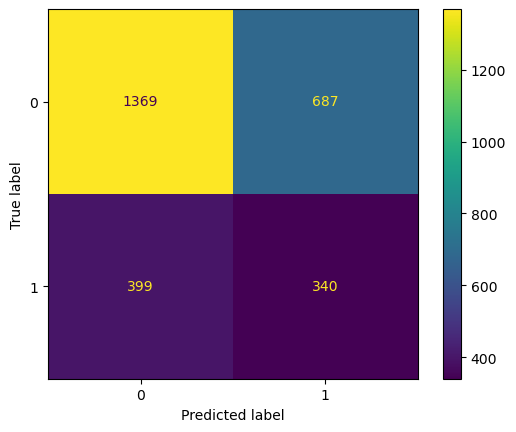

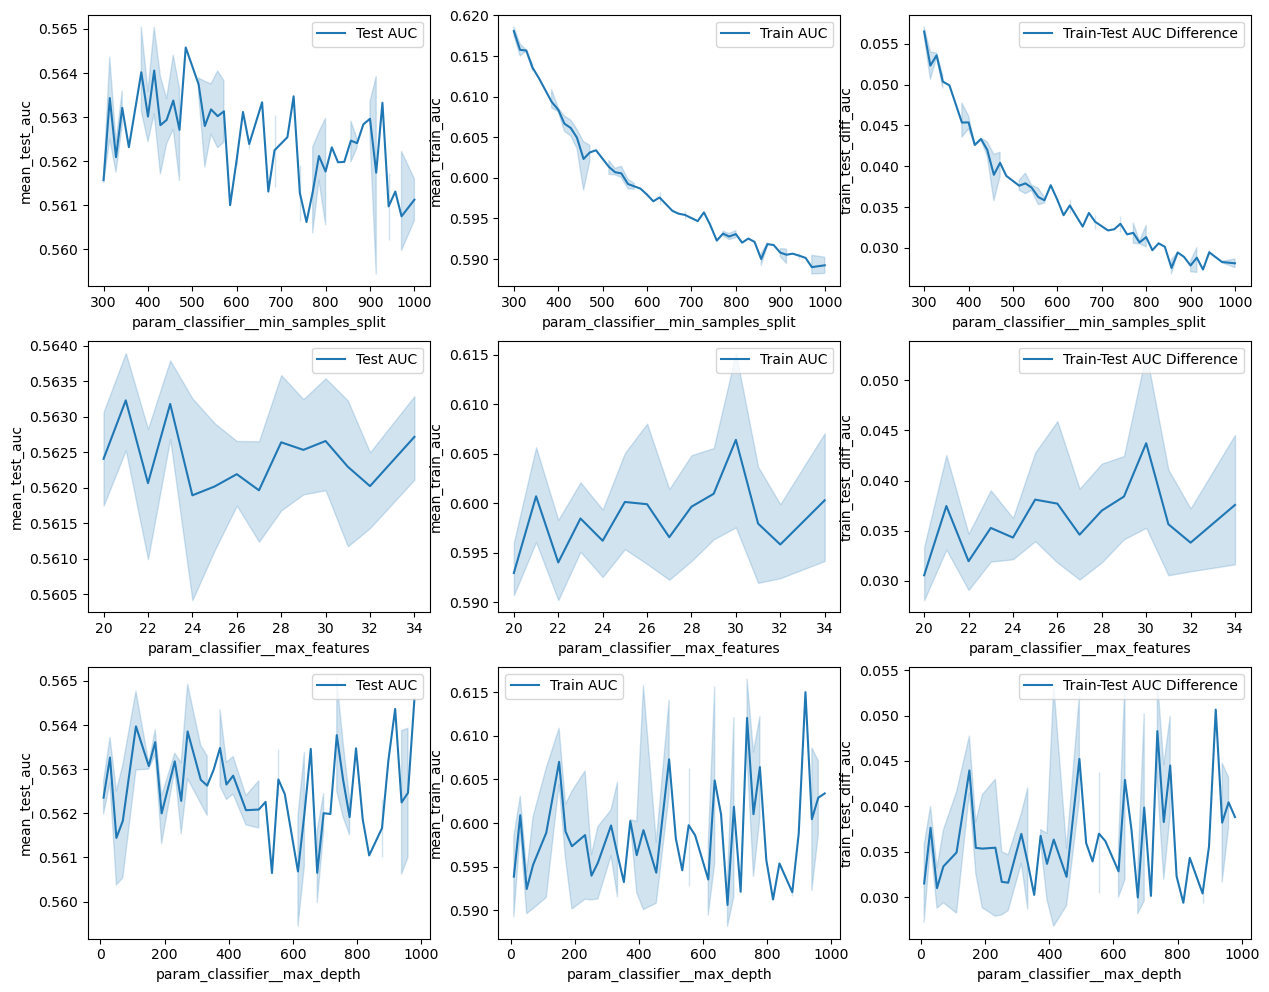

In [69]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(300, 1000, 50)],
        "classifier__max_features": [int(i) for i in np.linspace(20, 34, 14)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 1000, 50)] + [None]
    }
classifier = RandomForestClassifier(n_estimators=500, class_weight='balanced')
random_search = run_experiment(features, param_distributions, n_iter=100, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

#### 1. XGBoost

In [16]:
counter = Counter(df[target])
scale_pos_weight = counter[0] / counter[1]
scale_pos_weight

2.8485265767006336

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 20 is smaller than n_iter=300. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START classifier__eta=0.0........................................
[CV 1/3; 1/20] END classifier__eta=0.0; auc: (train=0.500, test=0.500) f1: (train=0.413, test=0.412) total time=   0.4s
[CV 2/3; 1/20] START classifier__eta=0.0........................................
[CV 2/3; 1/20] END classifier__eta=0.0; auc: (train=0.500, test=0.500) f1: (train=0.413, test=0.412) total time=   0.5s
[CV 3/3; 1/20] START classifier__eta=0.0........................................
[CV 3/3; 1/20] END classifier__eta=0.0; auc: (train=0.500, test=0.500) f1: (train=0.000, test=0.000) total time=   0.4s
[CV 1/3; 2/20] START classifier__eta=0.05263157894736842........................
[CV 1/3; 2/20] END classifier__eta=0.05263157894736842; auc: (train=0.655, test=0.537) f1: (train=0.495, test=0.340) total time=   0.4s
[CV 2/3; 2/20] START classifier__eta=0.05263157894736842........................
[CV 2/3; 2/20] END classifier__eta=0.0

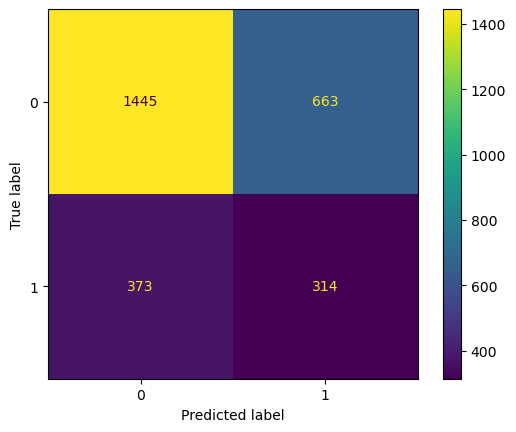

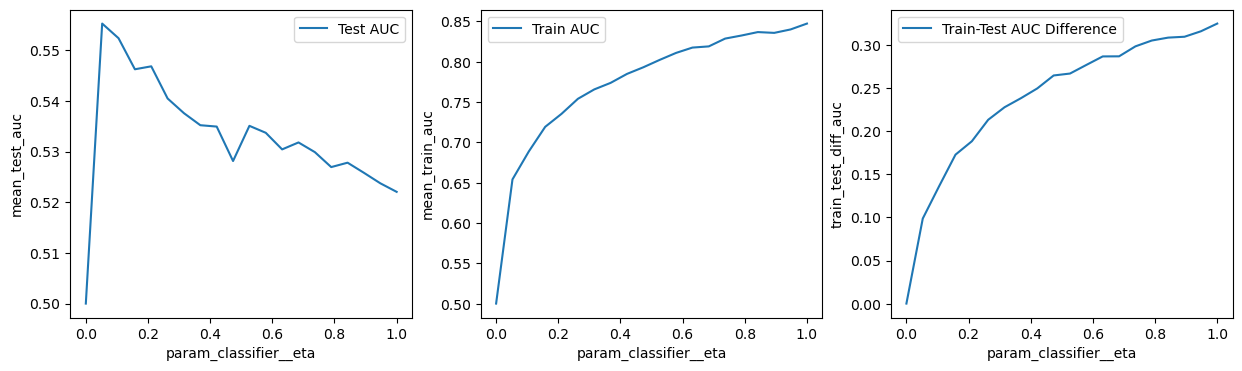

In [17]:
param_distributions = {
        "classifier__eta": [i for i in np.linspace(0, 1, 20)]
        #,"classifier__gamma": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__max_depth": [int(i) for i in np.linspace(2, 750, 50)]
        #,"classifier__lambda": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__alpha": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__min_child_weight": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__colsample_bytree": [i for i in np.linspace(0.5, 1, 10)]
    }
classifier = XGBClassifier(n_jobs=None, eval_metric='auc', scale_pos_weight=scale_pos_weight)
random_search = run_experiment(features, param_distributions, n_iter=300, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 20 is smaller than n_iter=300. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START classifier__gamma=20.0.....................................
[CV 1/3; 1/20] END classifier__gamma=20.0; auc: (train=0.579, test=0.554) f1: (train=0.420, test=0.397) total time=   0.3s
[CV 2/3; 1/20] START classifier__gamma=20.0.....................................
[CV 2/3; 1/20] END classifier__gamma=20.0; auc: (train=0.582, test=0.561) f1: (train=0.408, test=0.384) total time=   0.2s
[CV 3/3; 1/20] START classifier__gamma=20.0.....................................
[CV 3/3; 1/20] END classifier__gamma=20.0; auc: (train=0.574, test=0.580) f1: (train=0.398, test=0.417) total time=   0.2s
[CV 1/3; 2/20] START classifier__gamma=26.842105263157894.......................
[CV 1/3; 2/20] END classifier__gamma=26.842105263157894; auc: (train=0.576, test=0.559) f1: (train=0.415, test=0.394) total time=   0.2s
[CV 2/3; 2/20] START classifier__gamma=26.842105263157894.......................
[CV 2/3; 2/20] END classifie

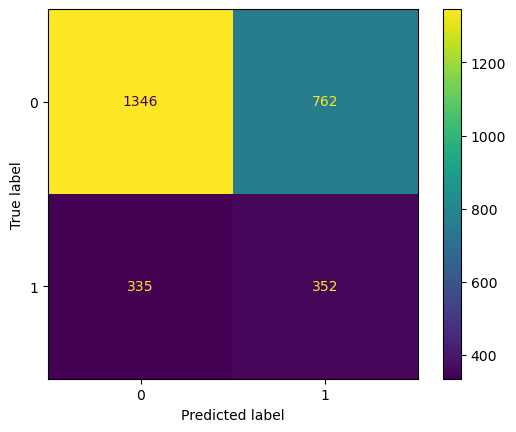

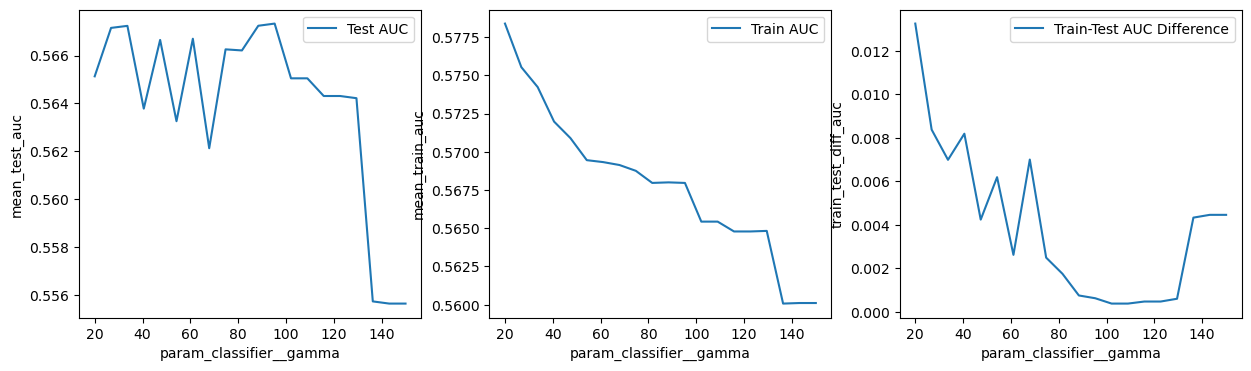

In [21]:
param_distributions = {
        "classifier__gamma": [i for i in np.linspace(20, 150, 20)]
        #,"classifier__max_depth": [int(i) for i in np.linspace(2, 750, 50)]
        #,"classifier__lambda": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__alpha": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__min_child_weight": [i for i in np.linspace(0, 20, 20)]
        #,"classifier__colsample_bytree": [i for i in np.linspace(0.5, 1, 10)]
    }
classifier = XGBClassifier(n_jobs=None, eval_metric='auc', scale_pos_weight=scale_pos_weight
                           , eta=0.05)
random_search = run_experiment(features, param_distributions, n_iter=300, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

optimising hyperparameters using Bayesian Optimisation

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [26]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(2, 750+1, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'lambda': hp.uniform('lambda', 0, 20),
    'alpha': hp.uniform('alpha', 0, 20),
    'gamma': hp.uniform('gamma', 0, 200),
    'min_child_weight': hp.uniform('min_child_weight', 0, 20)
}

# Define the objective function to minimize
def objective(params):
    classifier = XGBClassifier(n_jobs=None, eval_metric='auc', scale_pos_weight=scale_pos_weight, **params)
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500)
print("Best set of hyperparameters: ", best_params)

classifier = XGBClassifier(n_jobs=None, eval_metric='auc', scale_pos_weight=scale_pos_weight, **best_params)
pipeline = Pipeline([
    ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
    ('classifier', classifier)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
score = roc_auc_score(y_val, y_pred)
print("Best score: ", score)

100%|██████████| 5000/5000 [42:55<00:00,  1.94trial/s, best loss: -0.5923974487510398]
Best set of hyperparameters:  {'alpha': 4.472368911448472, 'gamma': 11.417832989420004, 'lambda': 11.05068737569529, 'learning_rate': 0.11453122900953377, 'max_depth': 310, 'min_child_weight': 15.120308690494067, 'subsample': 0.5161388474506781}
Best score:  0.5639731491821067


#### 3. k-NN

In [16]:
# Define the objective function to minimize
def objective(params):
    for param in params:
        classifier.param = params[param]
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy='not majority')),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

def hyperparameter_opt(params, max_evals):
    # Perform the optimization
    best_params = fmin(objective, params, algo=tpe.suggest, max_evals=max_evals)
    print("Best set of hyperparameters: ", best_params)

    for param in best_params:
        classifier.param = params[param]
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy='not majority')),        
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    print("Best score: ", score)

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot()

100%|██████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: -0.532687877301137]
Best set of hyperparameters:  {'leaf_size': 18, 'n_neighbors': 0, 'p': 7.9124116905406625, 'weights': 0}
Best score:  0.523834529620362


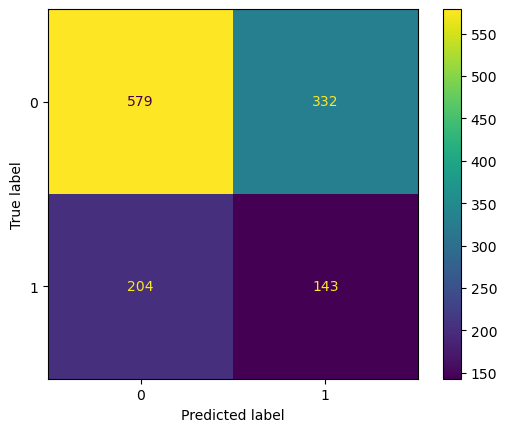

In [17]:
space = {
    'n_neighbors': hp.choice('n_neighbors', np.arange(1, 10+1, dtype=int)),
    'leaf_size': hp.choice('leaf_size', np.arange(2, 250+1, dtype=int)),
    'p': hp.uniform('p', 1, 10),
    'weights': hp.choice('weights', ["uniform", "distance"])
}
classifier = KNeighborsClassifier()
hyperparameter_opt(space, 100)

#### 4. SVM

In [18]:
# Define the objective function to minimize
def objective(params):
    for param in params:
        classifier.param = params[param]
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        #('over', SMOTE(sampling_strategy='not majority')),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

def hyperparameter_opt(params, max_evals):
    # Perform the optimization
    best_params = fmin(objective, params, algo=tpe.suggest, max_evals=max_evals)
    print("Best set of hyperparameters: ", best_params)

    for param in best_params:
        classifier.param = params[param]
    pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        #('over', SMOTE(sampling_strategy='not majority')),        
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    print("Best score: ", score)

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot()

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [49:42<00:00, 29.82s/trial, best loss: -0.5699140340024319]
Best set of hyperparameters:  {'C': 51.261350868553954, 'degree': 8, 'kernel': 1}
Best score:  0.5414023921522727


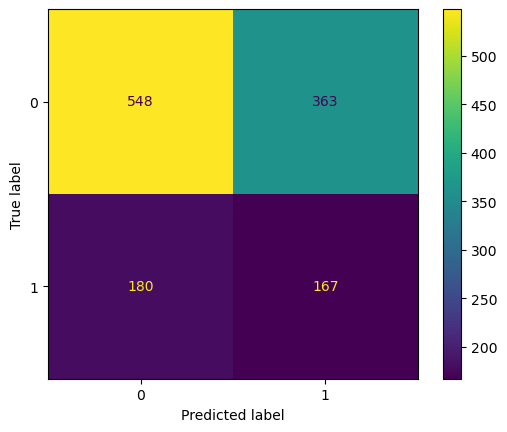

In [20]:
space = {
    'C': hp.uniform('C', 0, 100),
    'degree': hp.choice('degree', np.arange(1, 10, dtype=int)),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'])
}
classifier = SVC(class_weight='balanced')
hyperparameter_opt(space, 100)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START classifier__C=0.13265306122448978..........................
[CV 1/3; 1/20] END classifier__C=0.13265306122448978; auc: (train=0.656, test=0.541) f1: (train=0.492, test=0.304) total time=   6.9s
[CV 2/3; 1/20] START classifier__C=0.13265306122448978..........................
[CV 2/3; 1/20] END classifier__C=0.13265306122448978; auc: (train=0.663, test=0.541) f1: (train=0.502, test=0.341) total time=   6.5s
[CV 3/3; 1/20] START classifier__C=0.13265306122448978..........................
[CV 3/3; 1/20] END classifier__C=0.13265306122448978; auc: (train=0.668, test=0.545) f1: (train=0.509, test=0.355) total time=   6.1s
[CV 1/3; 2/20] START classifier__C=0.39795918367346933..........................
[CV 1/3; 2/20] END classifier__C=0.39795918367346933; auc: (train=0.682, test=0.531) f1: (train=0.529, test=0.314) total time=   9.0s
[CV 2/3; 2/20] START classifier__C=0.39795918367346933.........................

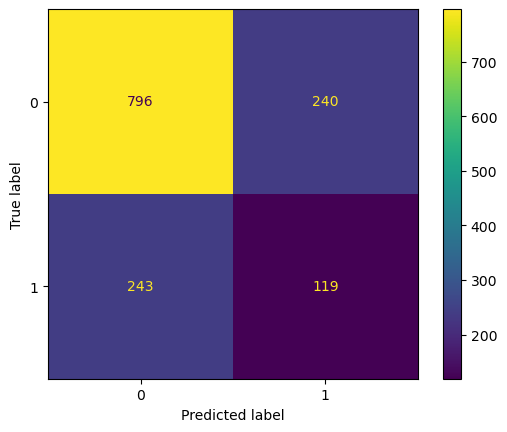

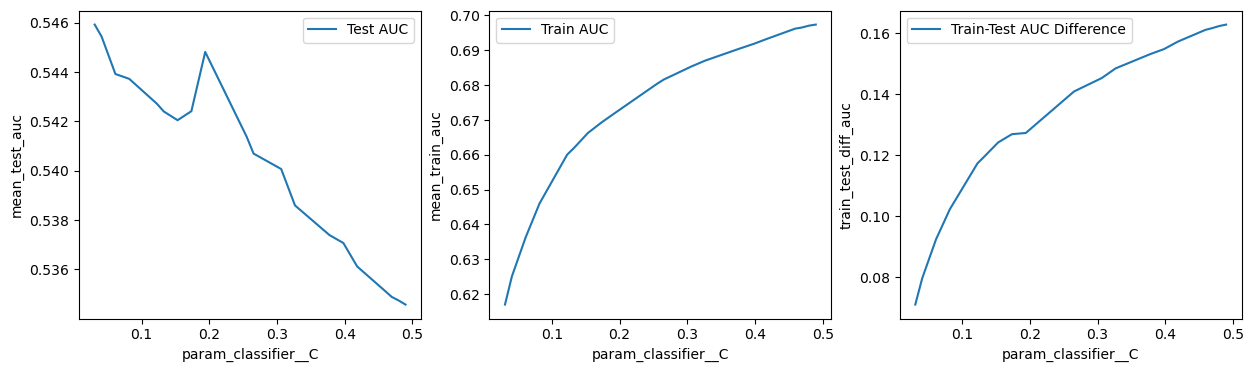

In [39]:
param_distributions = {
        "classifier__C": [i for i in np.linspace(0, 0.5, 50)]
    }
classifier = SVC(class_weight='balanced', **{'degree': 8, 'kernel': 'poly'})
random_search = run_experiment(features, param_distributions, n_iter=20, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START classifier__C=0.02653061224489796..........................
[CV 1/3; 1/20] END classifier__C=0.02653061224489796; auc: (train=0.614, test=0.543) f1: (train=0.428, test=0.277) total time=   6.4s
[CV 2/3; 1/20] START classifier__C=0.02653061224489796..........................
[CV 2/3; 1/20] END classifier__C=0.02653061224489796; auc: (train=0.609, test=0.544) f1: (train=0.415, test=0.323) total time=   6.6s
[CV 3/3; 1/20] START classifier__C=0.02653061224489796..........................
[CV 3/3; 1/20] END classifier__C=0.02653061224489796; auc: (train=0.617, test=0.554) f1: (train=0.431, test=0.357) total time=   6.3s
[CV 1/3; 2/20] START classifier__C=0.07959183673469389..........................
[CV 1/3; 2/20] END classifier__C=0.07959183673469389; auc: (train=0.640, test=0.548) f1: (train=0.470, test=0.305) total time=   6.5s
[CV 2/3; 2/20] START classifier__C=0.07959183673469389.........................

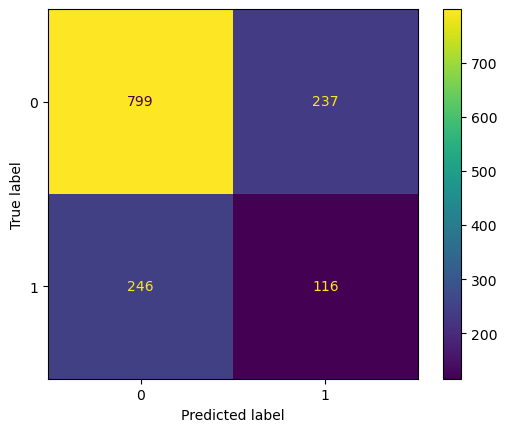

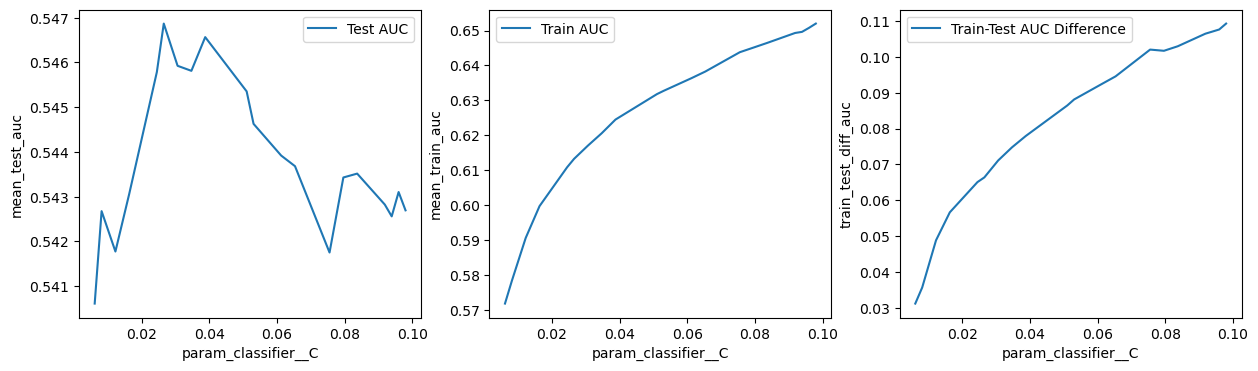

In [49]:
param_distributions = {
        "classifier__C": [i for i in np.linspace(0, 0.1, 50)]
    }
classifier = SVC(class_weight='balanced', **{'degree': 8, 'kernel': 'poly'})
random_search = run_experiment(features, param_distributions, n_iter=20, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

#### 5. Logistic Regression

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START classifier__C=0.05306122448979592..........................
[CV 1/3; 1/30] END classifier__C=0.05306122448979592; auc: (train=0.580, test=0.558) f1: (train=0.409, test=0.385) total time=   0.2s
[CV 2/3; 1/30] START classifier__C=0.05306122448979592..........................
[CV 2/3; 1/30] END classifier__C=0.05306122448979592; auc: (train=0.581, test=0.558) f1: (train=0.412, test=0.390) total time=   0.1s
[CV 3/3; 1/30] START classifier__C=0.05306122448979592..........................
[CV 3/3; 1/30] END classifier__C=0.05306122448979592; auc: (train=0.578, test=0.577) f1: (train=0.409, test=0.419) total time=   0.1s
[CV 1/3; 2/30] START classifier__C=0.15918367346938778..........................
[CV 1/3; 2/30] END classifier__C=0.15918367346938778; auc: (train=0.583, test=0.565) f1: (train=0.414, test=0.393) total time=   0.1s
[CV 2/3; 2/30] START classifier__C=0.15918367346938778.........................

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\imblearn\pipeline.py", line 333, in 

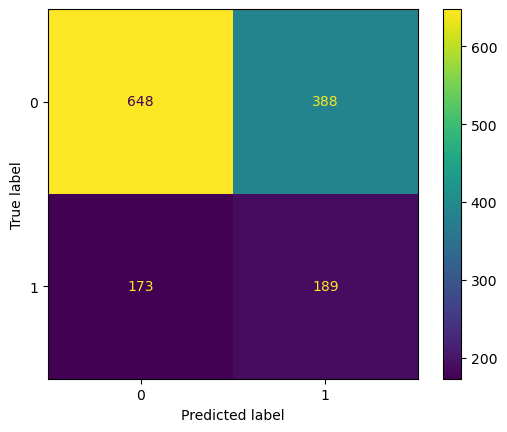

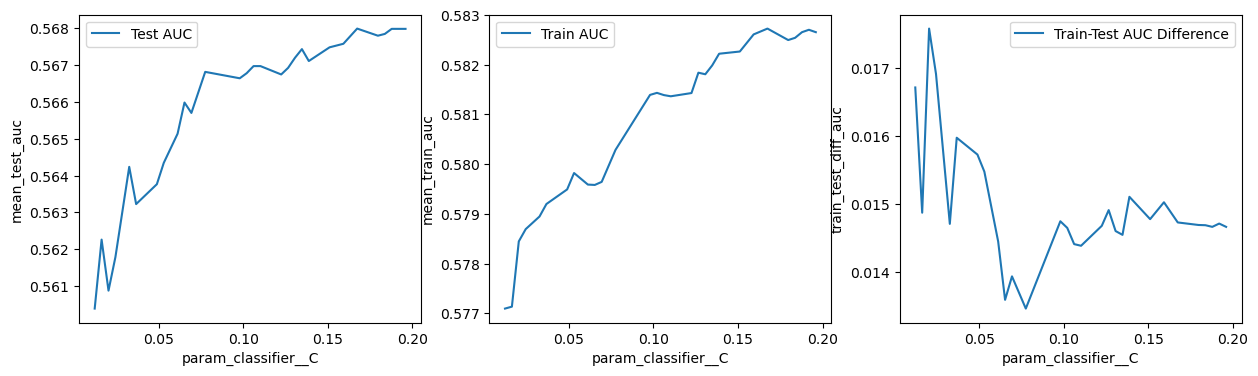

In [40]:
param_distributions = {
        "classifier__C": [i for i in np.linspace(0.0001, 0.2, 50)]
    }
classifier = LogisticRegression(class_weight='balanced', solver='newton-cholesky', penalty='l2')
random_search = run_experiment(features, param_distributions, n_iter=30, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START classifier__C=0.22367346938775512..........................
[CV 1/3; 1/30] END classifier__C=0.22367346938775512; auc: (train=0.582, test=0.565) f1: (train=0.413, test=0.394) total time=   0.1s
[CV 2/3; 1/30] START classifier__C=0.22367346938775512..........................
[CV 2/3; 1/30] END classifier__C=0.22367346938775512; auc: (train=0.584, test=0.561) f1: (train=0.415, test=0.393) total time=   0.1s
[CV 3/3; 1/30] START classifier__C=0.22367346938775512..........................
[CV 3/3; 1/30] END classifier__C=0.22367346938775512; auc: (train=0.581, test=0.577) f1: (train=0.412, test=0.420) total time=   0.1s
[CV 1/3; 2/30] START classifier__C=0.3510204081632653...........................
[CV 1/3; 2/30] END classifier__C=0.3510204081632653; auc: (train=0.581, test=0.565) f1: (train=0.412, test=0.393) total time=   0.1s
[CV 2/3; 2/30] START classifier__C=0.3510204081632653...........................

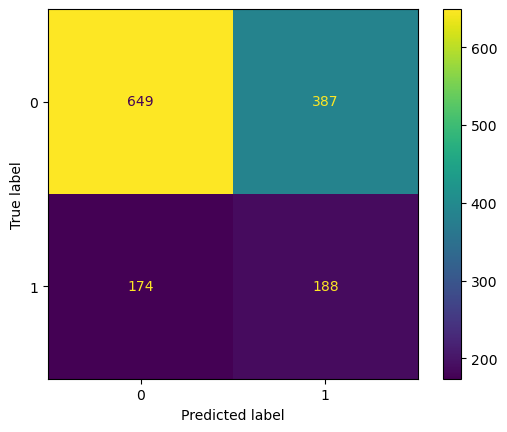

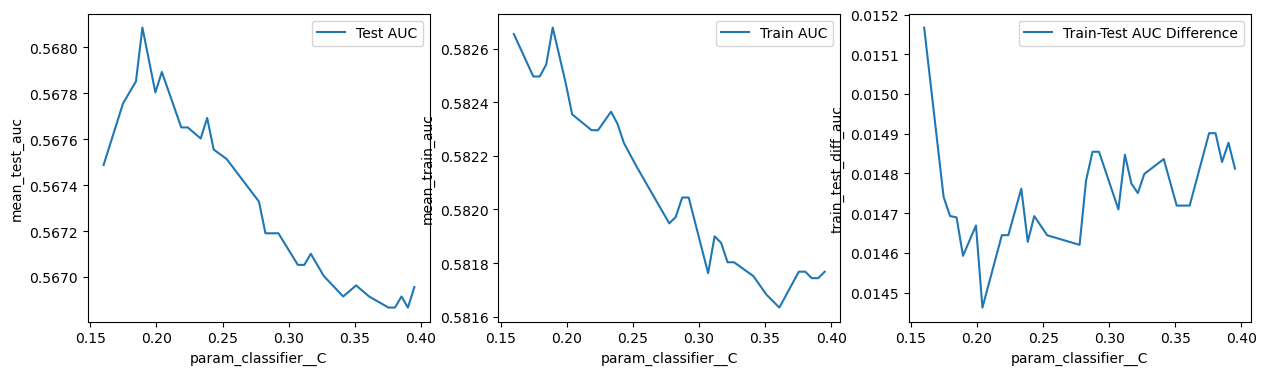

In [41]:
param_distributions = {
        "classifier__C": [i for i in np.linspace(0.16, 0.4, 50)]
    }
classifier = LogisticRegression(class_weight='balanced', solver='newton-cholesky', penalty='l2')
random_search = run_experiment(features, param_distributions, n_iter=30, n_splits=3, classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)